In [1]:
# ! pip install xport
# cd resources/2015-2016
# !python -m xport GHB_I.XPT > lab.csv
# !python -m xport BPX_I.XPT > bp.csv

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.metrics import accuracy_score as score
from sklearn.impute import SimpleImputer
import seaborn as sns

In [4]:
file_1 = pd.read_csv('resources/2013-2014/demographic.csv')
file_2 = pd.read_csv('resources/2013-2014/examination.csv')
file_3 = pd.read_csv('resources/2013-2014/labs.csv')
file_4 = pd.read_csv('resources/2015-2016/demographic.csv')
file_5 = pd.read_csv('resources/2015-2016/examination.csv')
file_6 = pd.read_csv('resources/2015-2016/labs.csv')
file_7 = pd.read_csv('resources/2015-2016/bp.csv')

df_1 = pd.DataFrame(file_1)
df_2 = pd.DataFrame(file_2)
df_3 = pd.DataFrame(file_3)
df_4 = pd.DataFrame(file_4)
df_5 = pd.DataFrame(file_5)
df_6 = pd.DataFrame(file_6)
df_7 = pd.DataFrame(file_7)

# merged=reduce(lambda left,right: pd.merge(left, right, on=['SEQN'], how='inner'), dataframes_1)
# merged.dropna(how='all', axis=1)
# merged.dropna(how='all', axis=0)

dataframes_1 = [df_1,df_2,df_3]
dataframes_2 = [df_4,df_5,df_6,df_7]

df_1 = reduce(lambda left, right: pd.merge(left,right,on='SEQN'), dataframes_1)
df_2 = reduce(lambda left, right: pd.merge(left,right,on='SEQN'), dataframes_2)

print('2013-2014 Dataframe')
print('columns: ' + str(len(df_1.columns.tolist())))
print('rows: ' + str(len(df_1.index)))
print('-----------------------')
print('2015-2016 Dataframe')
print('columns: ' + str(len(df_2.columns.tolist())))
print('rows: ' + str(len(df_2.index)))

#2015-2016 data does not contain grip strength
df1 = df_1.loc[:,['SEQN','RIDAGEYR','BPXSY2','BPXDI2','BMXWAIST','BMXBMI','BMXARMC','BPXPLS','LBXGH']]
df2 = df_2.loc[:,['SEQN','RIDAGEYR','BPXSY2','BPXDI2','BMXWAIST','BMXBMI','BMXARMC','BPXPLS','LBXGH']]


2013-2014 Dataframe
columns: 693
rows: 9813
-----------------------
2015-2016 Dataframe
columns: 93
rows: 6744


In [5]:
df2.isna().sum()

SEQN          0
RIDAGEYR      0
BPXSY2      243
BPXDI2      243
BMXWAIST    414
BMXBMI       84
BMXARMC     351
BPXPLS      190
LBXGH       418
dtype: int64

In [6]:
df = pd.concat([df1,df2])
df = df.rename(columns ={
    'SEQN': 'seqn',
    'RIAGENDR': 'gender',
    'RIDAGEYR': 'age',
    'RIDRETH3': 'ethnicity',
    'DMDEDUC3': 'education_child',
    'DMDEDUC2': 'education_adult',
    'INDHHIN2': 'household_income',
    'BMXWAIST': 'waist_circumference',
    'MGDCGSZ': 'grip',
    'BMXBMI': 'bmi',
    'BMXARMC': 'arm_circumference',
    'BPXPLS': 'pulse_60s',
    'BPXSY2': 'systolic',
    'BPXDI2': 'diastolic',
    'LBXGH': 'glycohemoglobin'
})
df.tail()

,seqn,age,systolic,diastolic,waist_circumference,bmi,arm_circumference,pulse_60s,glycohemoglobin
6739,93695.0,76.0,112.0,46.0,95.0,21.5,29.5,78.0,5.6
6740,93696.0,26.0,116.0,76.0,110.2,33.8,42.3,80.0,NaN
6741,93697.0,80.0,146.0,58.0,NaN,31.0,28.8,74.0,5.7
6742,93700.0,35.0,106.0,66.0,98.9,26.0,30.6,76.0,5.2
6743,93702.0,24.0,114.0,68.0,72.5,21.4,26.2,80.0,4.6


In [7]:
# checking nulls
df.isna().sum()

seqn                      0
age                       0
systolic               2647
diastolic              2647
waist_circumference    1566
bmi                     842
arm_circumference       863
pulse_60s              2454
glycohemoglobin        3588
dtype: int64

In [8]:
# WebMD definition of diabetes based on glycated hemoglobin levels.
# 3 classification labels

conditions = [
    (df['glycohemoglobin'] < 5.7),
    (df['glycohemoglobin'] >= 5.7) & (df['glycohemoglobin']<=6.4),
    (df['glycohemoglobin']>6.4)
]

diagnosis = [0,1,2]

df['diabetes'] = np.select(conditions, diagnosis)

# dropping rows where glycohemoglobin and pulse (if pulse is null --> syst/diast is null) is NaN 
# dropping rows where waist circum is null since there are 539 missing
# dropping rows where sys in null; 156 missing

df.dropna(axis=0, subset=['glycohemoglobin','pulse_60s','waist_circumference','systolic'],inplace=True)
df.isna().sum()

seqn                    0
age                     0
systolic                0
diastolic               0
waist_circumference     0
bmi                    22
arm_circumference      13
pulse_60s               0
glycohemoglobin         0
diabetes                0
dtype: int64

In [9]:
df.describe()

,seqn,age,systolic,diastolic,waist_circumference,bmi,arm_circumference,pulse_60s,glycohemoglobin,diabetes
count,11900.000000,11900.000000,11900.000000,11900.000000,11900.000000,11878.000000,11887.000000,11900.000000,11900.000000,11900.000000
mean,83611.942185,42.696387,121.335630,67.455462,96.621639,28.358680,32.398015,73.264202,5.680849,0.433529
std,5783.627421,20.375734,17.860445,13.810087,17.682366,7.086386,5.444553,11.766038,1.042651,0.662365
min,73557.000000,12.000000,66.000000,0.000000,54.600000,13.400000,17.100000,36.000000,3.500000,0.000000
25%,78664.750000,24.000000,108.000000,60.000000,83.600000,23.300000,28.600000,64.000000,5.200000,0.000000
50%,83556.500000,42.000000,118.000000,68.000000,95.500000,27.300000,32.000000,72.000000,5.500000,0.000000
75%,88654.750000,60.000000,130.000000,76.000000,107.400000,32.000000,35.800000,80.000000,5.800000,1.000000
max,93702.000000,80.000000,238.000000,130.000000,177.900000,74.100000,59.400000,148.000000,17.500000,2.000000


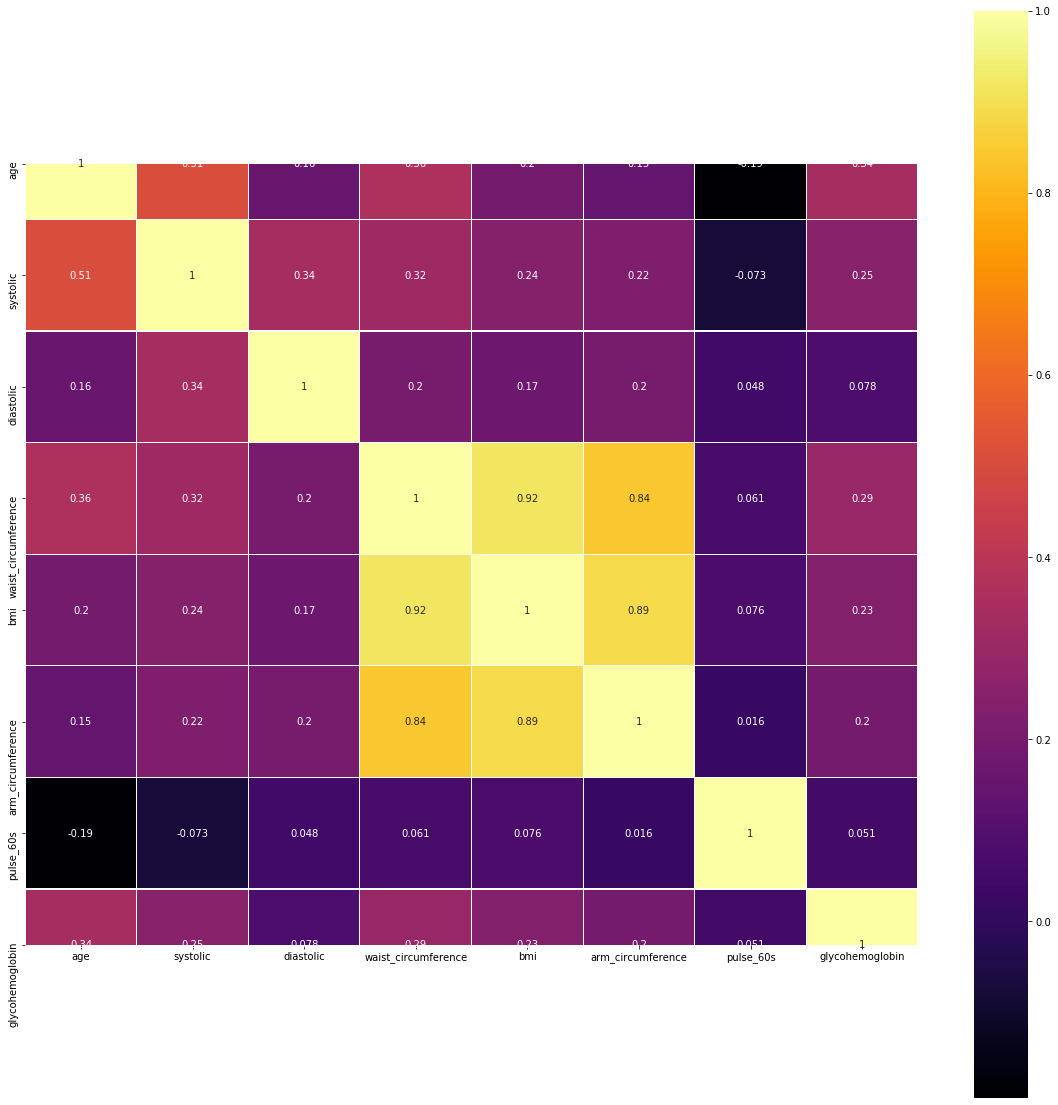

In [10]:
cm = plt.cm.inferno
plt.figure(figsize= (20,20))
sns.heatmap(df.drop('diabetes', axis=1).drop('seqn', axis=1).\
            astype(float).corr(), linewidths= 0.1, vmax=1, square=True, cmap=cm, annot=True)

In [11]:
# Proportions of labels in cleaned datset
print('Label Proportion in Clean Dataset')
print('non-diabetic: ' + str(df['diabetes'].value_counts()[0]/df['diabetes'].value_counts().sum()))
print('non-diabetic: ' + str(df['diabetes'].value_counts()[1]/df['diabetes'].value_counts().sum()))
print('non-diabetic: ' + str(df['diabetes'].value_counts()[2]/df['diabetes'].value_counts().sum()))

Label Proportion in Clean Dataset
non-diabetic: 0.6630252100840336
non-diabetic: 0.24042016806722688
non-diabetic: 0.0965546218487395


In [12]:
df_final = df.drop('seqn',axis=1).drop('glycohemoglobin',axis=1).copy()
list(enumerate(list(df_final)))

[(0, 'age'),
 (1, 'systolic'),
 (2, 'diastolic'),
 (3, 'waist_circumference'),
 (4, 'bmi'),
 (5, 'arm_circumference'),
 (6, 'pulse_60s'),
 (7, 'diabetes')]

In [17]:
features = df_final.iloc[:,0:7].values
labels = df_final.iloc[:,7].values

from sklearn.preprocessing import Imputer

imputer = Imputer(missing_values= 'NaN', strategy='median', axis=0)
imputer.fit(features[:, [4,5]])
features[:, [4,5]] = imputer.fit_transform(features[:, [4,5]])

df_features = pd.DataFrame(features)

X = df_features.iloc[:,:].values
y = labels

df_features.isnull().sum()

/Users/mohamedmartino/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


0    0
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64

## Random Forest Classifier

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, train_size=0.8)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=1000, random_state=0,criterion='entropy')
classifier.fit(X_train, y_train)
y_pred = (classifier.predict(X_test))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
score(y_test, y_pred)

[[1396  156   26]
 [ 328  208   36]
 [  87  111   32]]


0.6873949579831933

## PCA + Random Forest

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,train_size=0.8)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# PCA + RandomForest
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_

# explained_variance

classifier = RandomForestClassifier(n_estimators=100, random_state=0,criterion='entropy')
classifier.fit(X_train, y_train)
y_pred = (classifier.predict(X_test))

cm = confusion_matrix(y_test, y_pred)
print(cm)
score(y_test, y_pred)

[[1335  194   49]
 [ 375  159   38]
 [ 117   82   31]]


0.6407563025210085

## Logistic Regression

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, train_size=0.8)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# from sklearn.linear_model import LogisticRegression
# pca = PCA(n_components = 2)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)
# explained_variance = pca.explained_variance_ratio_

# explained_variance
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
score(y_test, y_pred)

[[1428  141    9]
 [ 353  206   13]
 [ 117   99   14]]


/Users/mohamedmartino/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mohamedmartino/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.692436974789916

## PCA + Logistic Regression

In [27]:
# PCA + Logistic Regression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, train_size=0.8)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

from sklearn.linear_model import LogisticRegression
pca = PCA(n_components = 2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_

# explained_variance

classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
score(y_test, y_pred)

[[1452  126    0]
 [ 429  141    2]
 [ 159   71    0]]


/Users/mohamedmartino/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mohamedmartino/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6693277310924369

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


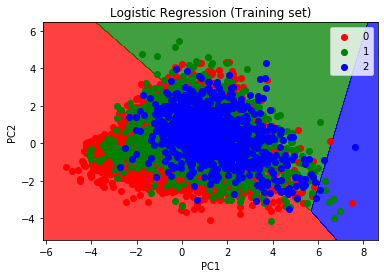

In [23]:
# Visualising the Training set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green', 'blue')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green', 'blue'))(i), label = j)
plt.title('Logistic Regression (Training set)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

## Naive Bayes

In [28]:
# PCA + Logistic Regression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, train_size=0.8)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# from sklearn.linear_model import LogisticRegression
# pca = PCA(n_components = 2)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)
# explained_variance = pca.explained_variance_ratio_

# explained_variance
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
score(y_test, y_pred)

[[1274  244   60]
 [ 273  223   76]
 [  77   96   57]]


0.6529411764705882

## Naive Bayes + PCA

In [30]:
# PCA + Logistic Regression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, train_size=0.8)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

from sklearn.linear_model import LogisticRegression
pca = PCA(n_components = 2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_

# explained_variance
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
score(y_test, y_pred)

[[1446  132    0]
 [ 447  125    0]
 [ 168   62    0]]


0.6600840336134454

## SVM

In [31]:
# PCA + Logistic Regression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, train_size=0.8)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# from sklearn.linear_model import LogisticRegression
# pca = PCA(n_components = 2)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)
# explained_variance = pca.explained_variance_ratio_

# explained_variance
from sklearn.svm import SVC
classifier = SVC(kernel='linear', random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
score(y_test, y_pred)

[[1516   62    0]
 [ 467  105    0]
 [ 154   76    0]]


0.6810924369747899

## PCA + SVM

In [32]:
# PCA + Logistic Regression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, train_size=0.8)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

from sklearn.linear_model import LogisticRegression
pca = PCA(n_components = 2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
# explained_variance = pca.explained_variance_ratio_

# explained_variance
from sklearn.svm import SVC
classifier = SVC(kernel='linear', random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
score(y_test, y_pred)

[[1578    0    0]
 [ 572    0    0]
 [ 230    0    0]]


0.6630252100840336

## Neural Network

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

#Importing Keras packages
import keras
from keras.models import Sequential
from keras.layers import Dense


#Initializing the ANN
classifier = Sequential()

#Adding the input layer and the first hidden layer
classifier.add(Dense(output_dim=8,init='uniform',activation='relu',input_dim=7))

#Adding the second hidden layer
classifier.add(Dense(output_dim=8,init='uniform',activation='relu'))

#Adding the output layer
classifier.add(Dense(output_dim=1,init='uniform',activation='sigmoid'))

#Making predictions and evaluating the model
classifier.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

#Fit ANN to training set
classifier.fit(X_train,y_train,epochs=100)

#Predicting the test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred>0.5)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
cm

/Users/mohamedmartino/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=7, units=8, kernel_initializer="uniform")`
/Users/mohamedmartino/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=8, kernel_initializer="uniform")`
/Users/mohamedmartino/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`


Epoch 1/100
8330/8330 [==============================] - 0s 42us/step - loss: 0.5977 - accuracy: 0.6697
Epoch 2/100
8330/8330 [==============================] - 0s 28us/step - loss: 0.4226 - accuracy: 0.6552
Epoch 3/100
8330/8330 [==============================] - 0s 31us/step - loss: 0.3757 - accuracy: 0.6639
Epoch 4/100
8330/8330 [==============================] - 0s 27us/step - loss: 0.3595 - accuracy: 0.6676
Epoch 5/100
8330/8330 [==============================] - 0s 27us/step - loss: 0.3517 - accuracy: 0.6695
Epoch 6/100
8330/8330 [==============================] - 0s 27us/step - loss: 0.3457 - accuracy: 0.6707
Epoch 7/100
8330/8330 [==============================] - 0s 28us/step - loss: 0.3418 - accuracy: 0.6725
Epoch 8/100
8330/8330 [==============================] - 0s 28us/step - loss: 0.3384 - accuracy: 0.6708
Epoch 9/100
8330/8330 [==============================] - 0s 26us/step - loss: 0.3353 - accuracy: 0.6720
Epoch 10/100
8330/8330 [==============================] - 0s 28u

8330/8330 [==============================] - 0s 32us/step - loss: -4.4920 - accuracy: 0.6749
Epoch 79/100
8330/8330 [==============================] - 0s 28us/step - loss: -4.6993 - accuracy: 0.6783
Epoch 80/100
8330/8330 [==============================] - 0s 30us/step - loss: -4.8941 - accuracy: 0.6797
Epoch 81/100
8330/8330 [==============================] - 0s 29us/step - loss: -5.1035 - accuracy: 0.6766
Epoch 82/100
8330/8330 [==============================] - 0s 34us/step - loss: -5.3288 - accuracy: 0.6773
Epoch 83/100
8330/8330 [==============================] - 0s 27us/step - loss: -5.5685 - accuracy: 0.6790
Epoch 84/100
8330/8330 [==============================] - 0s 36us/step - loss: -5.7864 - accuracy: 0.6767
Epoch 85/100
8330/8330 [==============================] - 0s 38us/step - loss: -6.0436 - accuracy: 0.6752
Epoch 86/100
8330/8330 [==============================] - 0s 32us/step - loss: -6.2744 - accuracy: 0.6764
Epoch 87/100
8330/8330 [==============================] - 0

array([[1821,  516,    0],
       [ 327,  577,    0],
       [  66,  263,    0]])